# Railway Traffic Time Series Clustering 
This notebook presents an analysis on Railway Traffic Time Series Data. The data was collected through the planitmetro web site (http://planitmetro.com/data), i.e the Washington Metropolitan Area Transit Authority data.

This data has been cleaned up -stations which did not have any information about time were removed from the database. The dataset consists of over 28000 tuples, each representing a group of 5 tuples for a single station, identifying the number of average rides each day at 5 distinct times of the day (AM_PEAK, PM_PEAK, MIDDAY, LAATE NIGHT PEAK, EVENING). The data is accumulated for a period of approximately 6 years from Sept 2010 to Jan 2016.

To understand the 'distance' or correlation between stations, we use a algorithm called Sales Pattern Distance described [here](http://dline.info/fpaper/jdim/v10i4/1.pdf). The basic idea is to increase the distance between two stations based on *the overall variation between the %change in Passenger Density*. For example, if a Station A has 2 data values (Passenger Density) - 4000 & 5000, it means an increase of 25%. Similarly, Station B having 2 data values - 400 & 500, *also* has an increase of 25%. Thus, both these stations have the same variation and thus could belong to the same cluster.

Initially, we pre-process the data and compute the distance matrix.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.spatial.distance as ssd
# compute_distance_matrix is a function that calculates a distance matrix between train stations based
# on change in % passenger density.
import compute_distance_matrix as cdm
DATA_DIR = '../data'

In [2]:
data = pd.read_excel(f'{DATA_DIR}/maindb.xlsx', 'Sheet1')

In [3]:
data.head(10)

,Station,Year,Passengerdensity
0,Addison RoadAM Peak,20109,2303
1,Addison RoadEvening,20109,211
2,Addison RoadLate Night Peak,20109,5
3,Addison RoadMidday,20109,748
4,Addison RoadPM Peak,20109,399
5,AnacostiaAM Peak,20109,3141
6,AnacostiaEvening,20109,604
7,AnacostiaLate Night Peak,20109,20
8,AnacostiaMidday,20109,1860
9,AnacostiaPM Peak,20109,1664


In [4]:
df = data.groupby(['Station','Year'])['Passengerdensity'].mean().to_frame().reset_index()
stations = df['Station'].unique()

In [5]:
di_matrix = cdm.extract_data(df)

Distance matrix computation complete.


In [6]:
#di_matrix

Now that we have computed the distance matrix, we split the data into test and training sets and apply Agglomerative Clustering.

In [7]:
test_stations = stations[-20:]
mask = np.in1d(stations,test_stations)
training_stations = stations[np.where(~mask)]

# Create test and training data
test_data = df[df['Station'].isin(test_stations)]
train_data = df[df['Station'].isin(training_stations)]

# Print out sizes
print('Training data size: ', train_data.index.size)
print('Test data size: ', test_data.index.size)

Training data size:  21696
Test data size:  822


In [8]:
test_matrix = di_matrix.ix[di_matrix.index.isin(test_stations), di_matrix.columns.isin(test_stations)]
train_matrix = di_matrix.ix[di_matrix.index.isin(training_stations), di_matrix.columns.isin(training_stations)]

We split the data into two halves, we keep 20 stations as test data, which is visualized using a heatmap below. We can see that there a couple of stations that are very similar in their growth/fall of % Passenger Density, shown in pink.

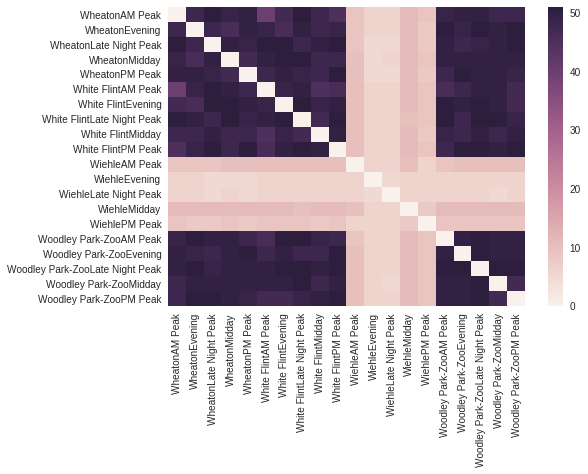

In [9]:
ax = sns.heatmap(test_matrix)

In [10]:
# Calculate clusters using Agglomerative Clustering using Euclidean Distance Measure.
# We keep the clusters at a fixed random number 10 for now. 
# Based on cluster evaluation, we can change this number.

clustering = AgglomerativeClustering(n_clusters=int(10))
clustering.fit(train_matrix)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward',
            memory=Memory(cachedir=None), n_clusters=10,
            pooling_func=<function mean at 0x7f5b1c030840>)

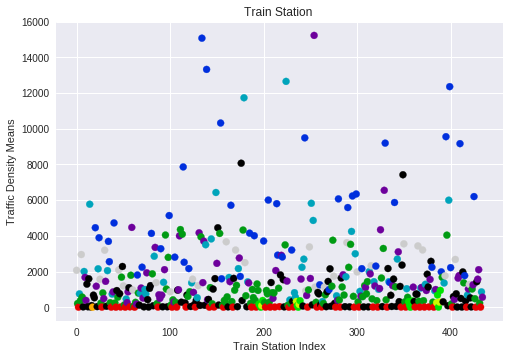

In [11]:
Y = train_data.groupby('Station')['Passengerdensity'].mean().as_matrix()
X = train_data.groupby('Station').mean().reset_index().index

plt.scatter(X,Y, c=clustering.labels_, cmap=plt.cm.spectral)
plt.title('Train Station ')
plt.xlabel('Train Station Index')
plt.ylabel('Traffic Density Means')

plt.rcParams["figure.figsize"] = [10,25]

plt.show()

In [12]:
cluster = dict()
for i in range(clustering.labels_.size):
    label = clustering.labels_[i]
    if label not in cluster:
        cluster[label] = [training_stations[i]]
    else:
        cluster[label].append(training_stations[i])

In [13]:
st_clusters = pd.DataFrame(dict([ ('Cluster ' + str(k),pd.Series(v)) for k,v in cluster.items() ])).fillna(value='').transpose()

In [14]:
st_clusters

,0,1,2,3,4,5,6,7,8,9,...,82,83,84,85,86,87,88,89,90,91
Cluster 0,AnacostiaLate Night Peak,Archives-Navy MemorialEvening,Archives-Navy MemorialLate Night Peak,Archives-Navy MemorialMidday,Arlington CemeteryAM Peak,Arlington CemeteryEvening,Arlington CemeteryMidday,Arlington CemeteryPM Peak,BallstonLate Night Peak,BethesdaLate Night Peak,...,Van Dorn StreetMidday,Van Ness-UDCEvening,Van Ness-UDCLate Night Peak,ViennaEvening,ViennaLate Night Peak,ViennaMidday,Virginia Square-GMUEvening,WaterfrontEvening,WaterfrontLate Night Peak,West Falls ChurchMidday
Cluster 1,AnacostiaPM Peak,Archives-Navy MemorialAM Peak,BallstonEvening,Benning RoadPM Peak,BethesdaEvening,Braddock RoadPM Peak,Capitol HeightsPM Peak,Capitol SouthAM Peak,Capitol SouthPM Peak,CheverlyPM Peak,...,,,,,,,,,,
Cluster 2,BallstonAM Peak,BallstonPM Peak,BethesdaPM Peak,Braddock RoadAM Peak,Branch AvenueAM Peak,ClarendonAM Peak,Cleveland ParkAM Peak,Columbia HeightsAM Peak,Court HouseAM Peak,Crystal CityPM Peak,...,,,,,,,,,,
Cluster 3,Addison RoadMidday,AnacostiaMidday,Archives-Navy MemorialPM Peak,BallstonMidday,BethesdaMidday,Braddock RoadMidday,Capitol HeightsMidday,ClarendonMidday,Cleveland ParkMidday,Cleveland ParkPM Peak,...,,,,,,,,,,
Cluster 4,Addison RoadEvening,Addison RoadPM Peak,AnacostiaEvening,Benning RoadEvening,Benning RoadMidday,Braddock RoadEvening,Branch AvenueEvening,Branch AvenuePM Peak,BrooklandMidday,Capitol HeightsEvening,...,TwinbrookEvening,U Street-CardozoEvening,Union StationEvening,Van Dorn StreetEvening,ViennaPM Peak,WaterfrontMidday,West Falls ChurchEvening,West HyattsvilleEvening,,
Cluster 5,GreensboroAM Peak,GreensboroEvening,GreensboroLate Night Peak,GreensboroPM Peak,McLeanEvening,McLeanLate Night Peak,McLeanPM Peak,Spring HillAM Peak,Spring HillEvening,Spring HillLate Night Peak,...,,,,,,,,,,
Cluster 6,GreensboroMidday,McLeanAM Peak,McLeanMidday,Tysons CornerAM Peak,Tysons CornerMidday,,,,,,...,,,,,,,,,,
Cluster 7,Arlington CemeteryLate Night Peak,,,,,,,,,,...,,,,,,,,,,
Cluster 8,Addison RoadLate Night Peak,Benning RoadLate Night Peak,Braddock RoadLate Night Peak,Branch AvenueLate Night Peak,BrooklandLate Night Peak,Capitol HeightsLate Night Peak,Capitol SouthLate Night Peak,CheverlyLate Night Peak,Congress HeightsLate Night Peak,DeanwoodLate Night Peak,...,,,,,,,,,,
Cluster 9,Addison RoadAM Peak,AnacostiaAM Peak,Benning RoadAM Peak,BethesdaAM Peak,BrooklandAM Peak,Capitol HeightsAM Peak,CheverlyAM Peak,Congress HeightsAM Peak,DeanwoodAM Peak,Eastern MarketPM Peak,...,,,,,,,,,,


In [15]:
st_clusters.to_excel('Training Data Set Clusters.xlsx', 'Sheet1')

In [16]:
# Find cluster center by mean of Passenger Density
cluster_means = dict()
for index, row in st_clusters.iterrows():
    traffic = train_data[train_data['Station'].isin(row)]
    traffic['Year'] = train_data.apply(lambda row: cdm.year_format(row['Year']), axis=1)
    cluster_means[index] = traffic.groupby('Year')['Passengerdensity'].mean()
    
cdf = pd.DataFrame(cluster_means).fillna(value=0)

/home/ishaan/.pyenv/versions/3.6.0/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


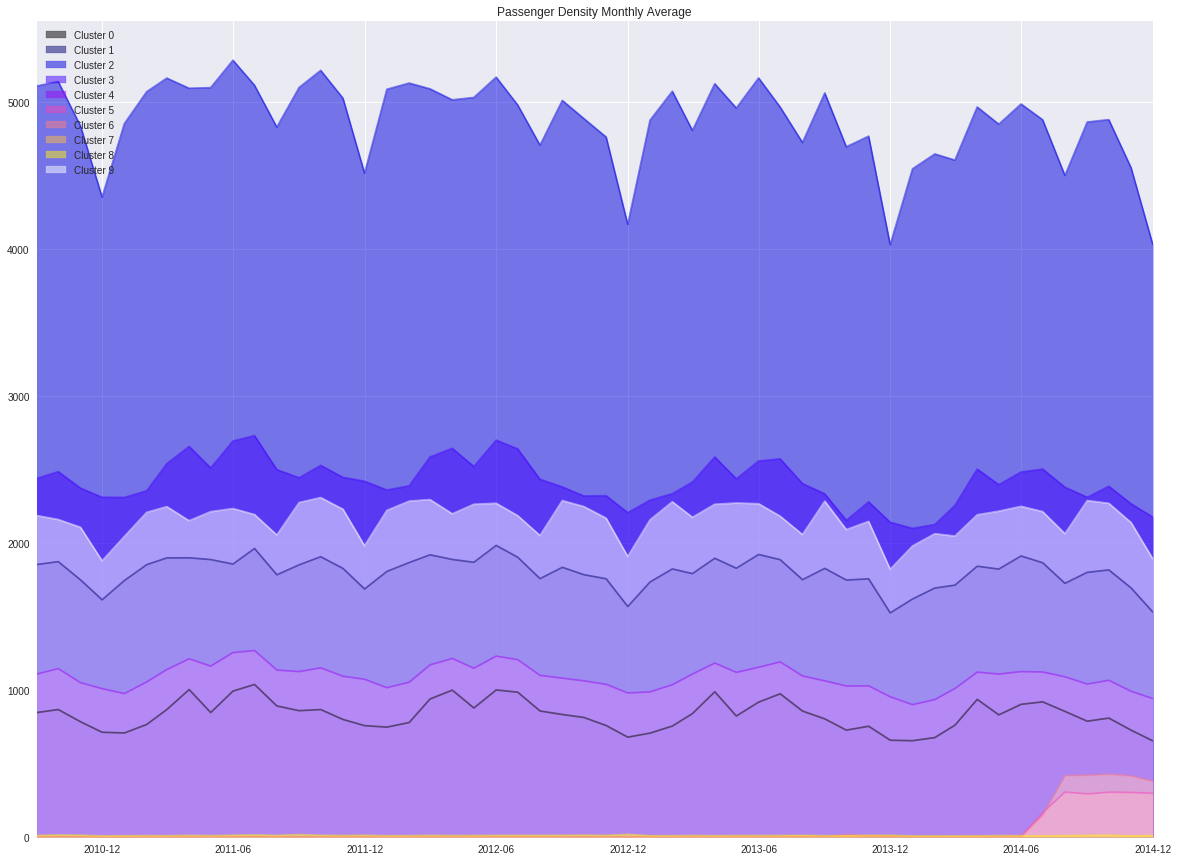

In [17]:
cdf.plot.area(stacked=False, figsize=[20,15], title='Passenger Density Monthly Average', cmap=plt.cm.gnuplot2)

As can be seen from the plot above of Passenger Density Mean vs Time, separate clusters have different curves. However, cluster 5 & 6 (purple-pink shades with ~1000 passenger density mean) appear very similar. They are differentiated only by the few instances where their individual % change in passenger densities vary a lot. For example, stations in cluster 5 have a greater increase in Passenger Density around April 2011 as compared to Cluster 6 (seen as a *sharper peak*). 

The clustering itself is based on grouping stations with *similar* variations.

In [18]:
cluster_centers = dict()

# Find cluster center by mean of Passenger Density

for index, row in st_clusters.iterrows():
    traffic = train_data[train_data['Station'].isin(row)]   
    traffic['Year'] = train_data.apply(lambda row: cdm.year_format(row['Year']), axis=1)
    cluster_centers[index] = dict()
    cluster_centers[index]['center'] = traffic['Passengerdensity'].mean()
    cluster_centers[index]['count'] = row[row != ''].size
    
cluster_centers

/home/ishaan/.pyenv/versions/3.6.0/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


{'Cluster 0': {'center': 829.55948149696837, 'count': 92},
 'Cluster 1': {'center': 1801.4004342431763, 'count': 62},
 'Cluster 2': {'center': 4873.0797275641025, 'count': 48},
 'Cluster 3': {'center': 2415.5432692307691, 'count': 48},
 'Cluster 4': {'center': 1088.6399572649573, 'count': 90},
 'Cluster 5': {'center': 254.60204081632654, 'count': 15},
 'Cluster 6': {'center': 221.06, 'count': 5},
 'Cluster 7': {'center': 1.1428571428571428, 'count': 1},
 'Cluster 8': {'center': 8.6396321070234112, 'count': 46},
 'Cluster 9': {'center': 2162.2348901098903, 'count': 28}}

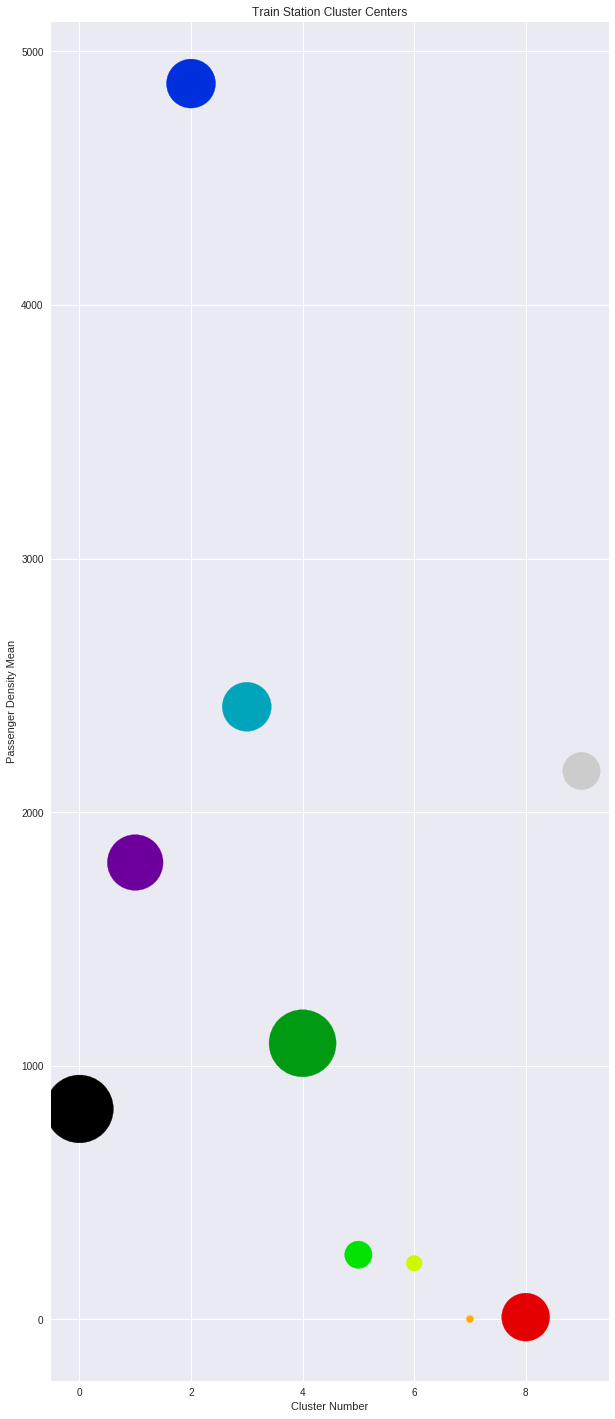

In [19]:
# plot cluster centers
data_points = pd.DataFrame(cluster_centers).T.reset_index()

Y = data_points['center'].values
X = range(data_points.index.size)

plt.scatter(X,Y, s=data_points['count']*50, c=X, cmap=plt.cm.spectral)
plt.title('Train Station Cluster Centers')
plt.xlabel('Cluster Number')
plt.ylabel('Passenger Density Mean')

plt.show()

The above scatter plot shows the sizes of the clusters and the order of the Passenger Densities of the stations within each cluster. Considering a mean of Passenger Density would seem counter intuitive since stations with different order of density can still be in the same cluster. However, it can be noted from the earlier time series plot that stations with similar orders tend to be in the same cluster. 

Moreover, we can see that Cluster 7 (the tiny orange point) is an outlier. It consists of only 1 station, and displays behaviour that is anomalous with respect to other stations.

# Predictive Analysis

Now that we have created the clusters, we evaluate our clustering method (agglomerative) by comparing it to BIRCH, and measuring cluster dispersion to find out the optimum no of clusters (remember, we had initially taken 10 clusters as default).

In [20]:
# Predict clusters for test data
predict_labels = clustering.fit_predict(test_matrix)
print("Agglomerative Clustering:" + str(list(predict_labels)))

# Compare the clustering with Birch
from sklearn.cluster import Birch
brc = Birch(branching_factor=50, n_clusters=10, threshold=0.5, compute_labels=True)
brc.fit(train_matrix)
print('BIRCH Clustering:\t ' + str(list(brc.fit_predict(test_matrix))))

Agglomerative Clustering:[2, 4, 0, 4, 9, 2, 8, 1, 1, 2, 3, 3, 3, 3, 3, 7, 0, 6, 5, 5]
BIRCH Clustering:	 [2, 4, 0, 4, 9, 2, 8, 1, 1, 2, 3, 3, 3, 3, 3, 7, 0, 6, 5, 5]


In [21]:
pred_cluster = dict()
for i in range(predict_labels.size):
    label = predict_labels[i]
    if label not in pred_cluster:
        pred_cluster[label] = [test_stations[i]]
    else:
        pred_cluster[label].append(test_stations[i])

In [22]:
print('Predicted Clusters:\n')
for k, v in pred_cluster.items():
    if v:
        for station in v:
            print(str(station) + "  =>  " + str(k))

Predicted Clusters:

WheatonAM Peak  =>  2
White FlintAM Peak  =>  2
White FlintPM Peak  =>  2
WheatonEvening  =>  4
WheatonMidday  =>  4
WheatonLate Night Peak  =>  0
Woodley Park-ZooEvening  =>  0
WheatonPM Peak  =>  9
White FlintEvening  =>  8
White FlintLate Night Peak  =>  1
White FlintMidday  =>  1
WiehleAM Peak  =>  3
WiehleEvening  =>  3
WiehleLate Night Peak  =>  3
WiehleMidday  =>  3
WiehlePM Peak  =>  3
Woodley Park-ZooAM Peak  =>  7
Woodley Park-ZooLate Night Peak  =>  6
Woodley Park-ZooMidday  =>  5
Woodley Park-ZooPM Peak  =>  5


## Cluster Evaluation

### Silhoutte Score

The Silhouette Coefficient is defined for each sample and is composed of two scores:

a: The mean distance between a sample and all other points in the same class.

b: The mean distance between a sample and all other points in the next nearest cluster.

The Silhouette Coefficient s for a single sample is then given as:
$$s = \frac{b - a}{max(a, b)}$$
The Silhouette Coefficient for a set of samples is given as the mean of the Silhouette Coefficient for each sample.

In [23]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances

print('Test data score: ' + str(metrics.silhouette_score(test_matrix, predict_labels, metric='euclidean')))
print('Training data score: ' + str(metrics.silhouette_score(train_matrix, clustering.fit_predict(train_matrix), metric='euclidean')))

Test data score: 0.241376574604
Training data score: 0.0526737648439


The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters. 

A 0.2 cluster score isn't great for the test data and it shows we have overlapping clusters in the training data itself. This is possible, and we figured this was happening when we plotted Passenger Density means with Time and saw that a few plot lines were very similar even though the passenger densities were in different orders of magnitude.

We now try the Calinski-Harabaz Index

### Calinski-Harabaz Index

For k clusters, the Calinski-Harabaz score s is given as the ratio of the between-clusters dispersion mean and the within-cluster dispersion:

$$s(k) = \frac{\mathrm{Tr}(B_k)}{\mathrm{Tr}(W_k)} \times \frac{N - k}{k - 1}$$

where $B_K$ is the between group dispersion matrix and $W_K$ is the within-cluster dispersion matrix defined by:

$$W_k = \sum_{q=1}^k \sum_{x \in C_q} (x - c_q) (x - c_q)^T$$

$$B_k = \sum_q n_q (c_q - c) (c_q - c)^T$$

with N be the number of points in our data, $C_q$ be the set of points in cluster q, $c_q$ be the center of cluster q, c be the center of  E, $n_q$ be the number of points in cluster q.

In [24]:
print('Test Data: ' + str(metrics.calinski_harabaz_score(test_matrix, predict_labels)))
print('Training Data: ' + str(metrics.calinski_harabaz_score(train_matrix, clustering.fit_predict(train_matrix))))

Test Data: 8.51233238295
Training Data: 550.117797116


We see here that the training data has higher score than the test data. This implies that even though the clusters are overlapping, they are sufficiently dense. This may be happening due to the small number of final clusters (fixed at 10). We now increase the value and see how the scores change.

In [25]:
test_sil = list()
train_sil = list()
test_cal = list()
train_cal = list()
for i in range(2,20):
    trial = AgglomerativeClustering(n_clusters=int(i))
    trial.fit(train_matrix)
    test_sil.append(metrics.silhouette_score(test_matrix, trial.fit_predict(test_matrix), metric='euclidean'))
    train_sil.append(metrics.silhouette_score(train_matrix, trial.fit_predict(train_matrix), metric='euclidean'))
    test_cal.append(metrics.calinski_harabaz_score(test_matrix, trial.fit_predict(test_matrix)))
    train_cal.append(metrics.calinski_harabaz_score(train_matrix, trial.fit_predict(train_matrix)))

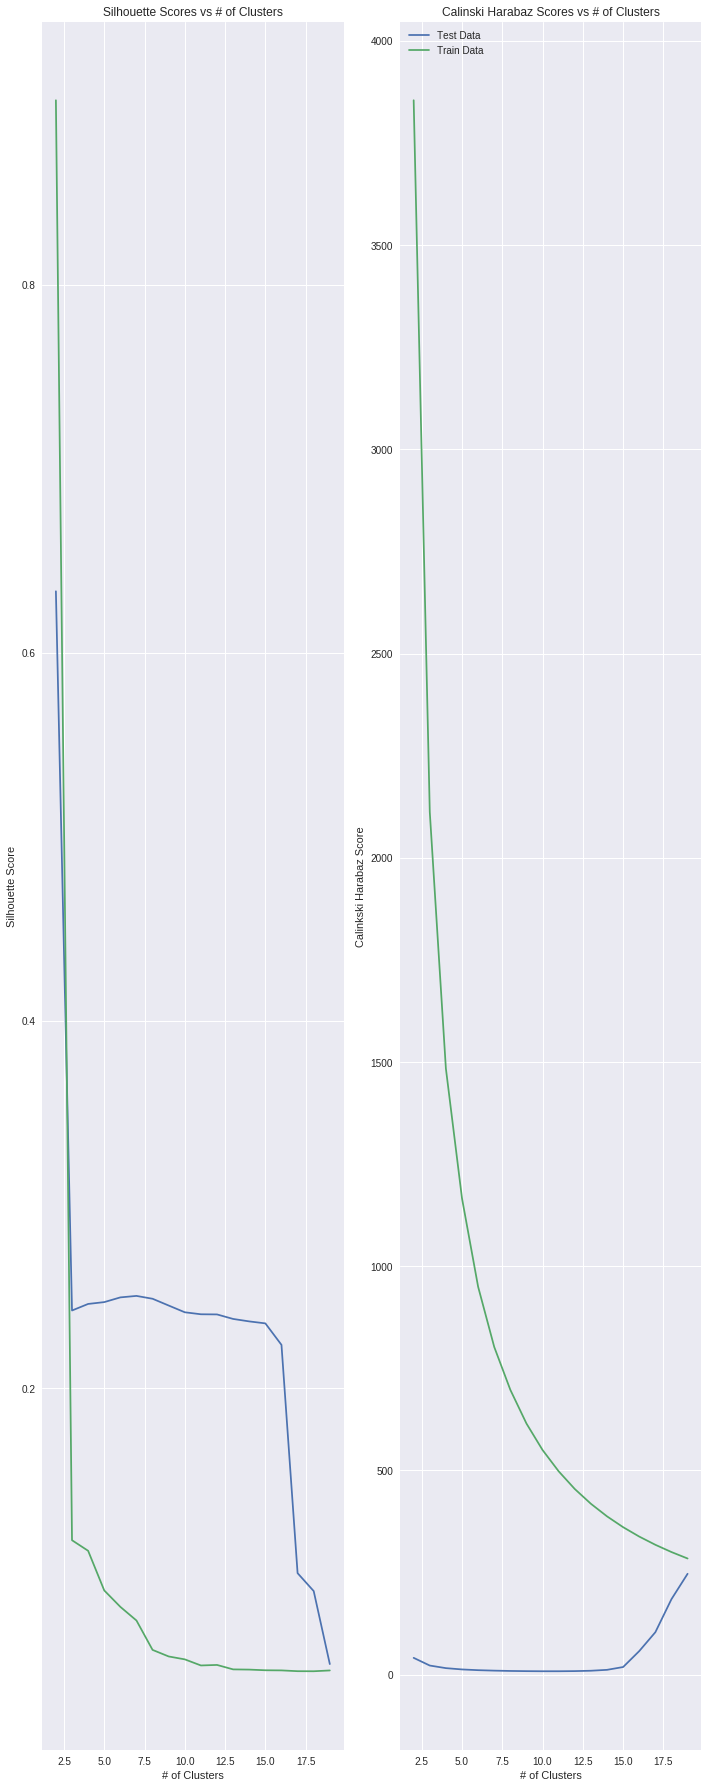

In [26]:
sil_plot = plt.subplot(1,2,1)
sil_plot.plot(range(2,20),test_sil, label='Test Data')
sil_plot.plot(range(2,20),train_sil, label='Train Data')

sil_plot.set_title('Silhouette Scores vs # of Clusters')
sil_plot.set_xlabel('# of Clusters')
sil_plot.set_ylabel('Silhouette Score')

cal_plot = plt.subplot(1,2,2)
cal_plot.plot(range(2,20),test_cal, label='Test Data')
cal_plot.plot(range(2,20),train_cal, label='Train Data')

cal_plot.set_title('Calinski Harabaz Scores vs # of Clusters')
cal_plot.set_xlabel('# of Clusters')
cal_plot.set_ylabel('Calinkski Harabaz Score')

plt.tight_layout()
plt.legend(loc='upper left')
plt.show()

## Intuition and Analysis
As can bee seen from the graphs, the Silhouette score drops with increase in the number of clusters. That is, increasing the number of clusters leads to overlapping. Moreover, while training data becomes almost constant at large no of clusters, the test data sharply decreases.

One of the reasons could be that since the data itself is dispersed in a certain way, increasing the number of clusters may actually lead to sparse overlapping clusters after a certain point. The BIRCH algorithm which I briefly use detects 20 clusters within the data with a threshold of 0.5.

As for the Calinski Harabaz score, increasing the number of clusters seem to exponentially increase the score for test data, while monotonically decreasing training data score. That is, as the number of clusters $k$ increases, $B(k)$ increases and $W(k)$ decreases. Since the Calinski Harabaz score is monotonically increasing/decreasing for training and test data, it may not be a reliable measure in this scenario.

In conclusion, a smaller number of clusters (~5) may be the best for this particular set of data. We see that at 2 clusters, the score sharply increases for both measures. Keep in mind that the data itself is clustered based on *Change in the Passenger Density growth/fall*, so even if a Station A has a Passenger Density of 4000 and Station B has a density of 400, they can be in the same cluster if these numbers grow/fall *by the same amount*.